In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [29]:
df = pd.read_csv('../data/data_STNE.csv')
df.head(10)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-10-25 00:00:00-04:00,32.000000,32.189999,30.000000,31.350000,22912000,0.0,0.0
1,2018-10-26 00:00:00-04:00,30.700001,31.209999,29.750000,31.090000,5137200,0.0,0.0
2,2018-10-29 00:00:00-04:00,32.240002,32.500000,29.000000,29.059999,2144900,0.0,0.0
3,2018-10-30 00:00:00-04:00,29.000000,29.400000,27.590000,28.680000,2613400,0.0,0.0
4,2018-10-31 00:00:00-04:00,29.129999,29.900000,28.500000,28.690001,1985000,0.0,0.0
5,2018-11-01 00:00:00-04:00,28.980000,29.879999,28.500000,29.420000,1491700,0.0,0.0
6,2018-11-02 00:00:00-04:00,29.860001,30.620001,29.600000,30.129999,872700,0.0,0.0
7,2018-11-05 00:00:00-05:00,30.350000,31.719999,29.959999,30.750000,693800,0.0,0.0
8,2018-11-06 00:00:00-05:00,30.690001,30.940001,29.510000,30.469999,462700,0.0,0.0
9,2018-11-07 00:00:00-05:00,30.500000,30.750000,29.350000,29.400000,622500,0.0,0.0


In [30]:
df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.date
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-10-25,32.000000,32.189999,30.00,31.350000,22912000,0.0,0.0
1,2018-10-26,30.700001,31.209999,29.75,31.090000,5137200,0.0,0.0
2,2018-10-29,32.240002,32.500000,29.00,29.059999,2144900,0.0,0.0
3,2018-10-30,29.000000,29.400000,27.59,28.680000,2613400,0.0,0.0
4,2018-10-31,29.129999,29.900000,28.50,28.690001,1985000,0.0,0.0


In [31]:
df['Variacao'] =  (df['Open'] - df['Close']) / df['Open']
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Variacao
0,2018-10-25,32.000000,32.189999,30.00,31.350000,22912000,0.0,0.0,0.020312
1,2018-10-26,30.700001,31.209999,29.75,31.090000,5137200,0.0,0.0,-0.012704
2,2018-10-29,32.240002,32.500000,29.00,29.059999,2144900,0.0,0.0,0.098635
3,2018-10-30,29.000000,29.400000,27.59,28.680000,2613400,0.0,0.0,0.011034
4,2018-10-31,29.129999,29.900000,28.50,28.690001,1985000,0.0,0.0,0.015105


In [32]:
variation = [df['Variacao'] == 0,
            df['Variacao'] > 0,
            df['Variacao'] < 0]

colours = ['blue', 'green', 'red']

colours_np = np.select(variation, colours, default='black')


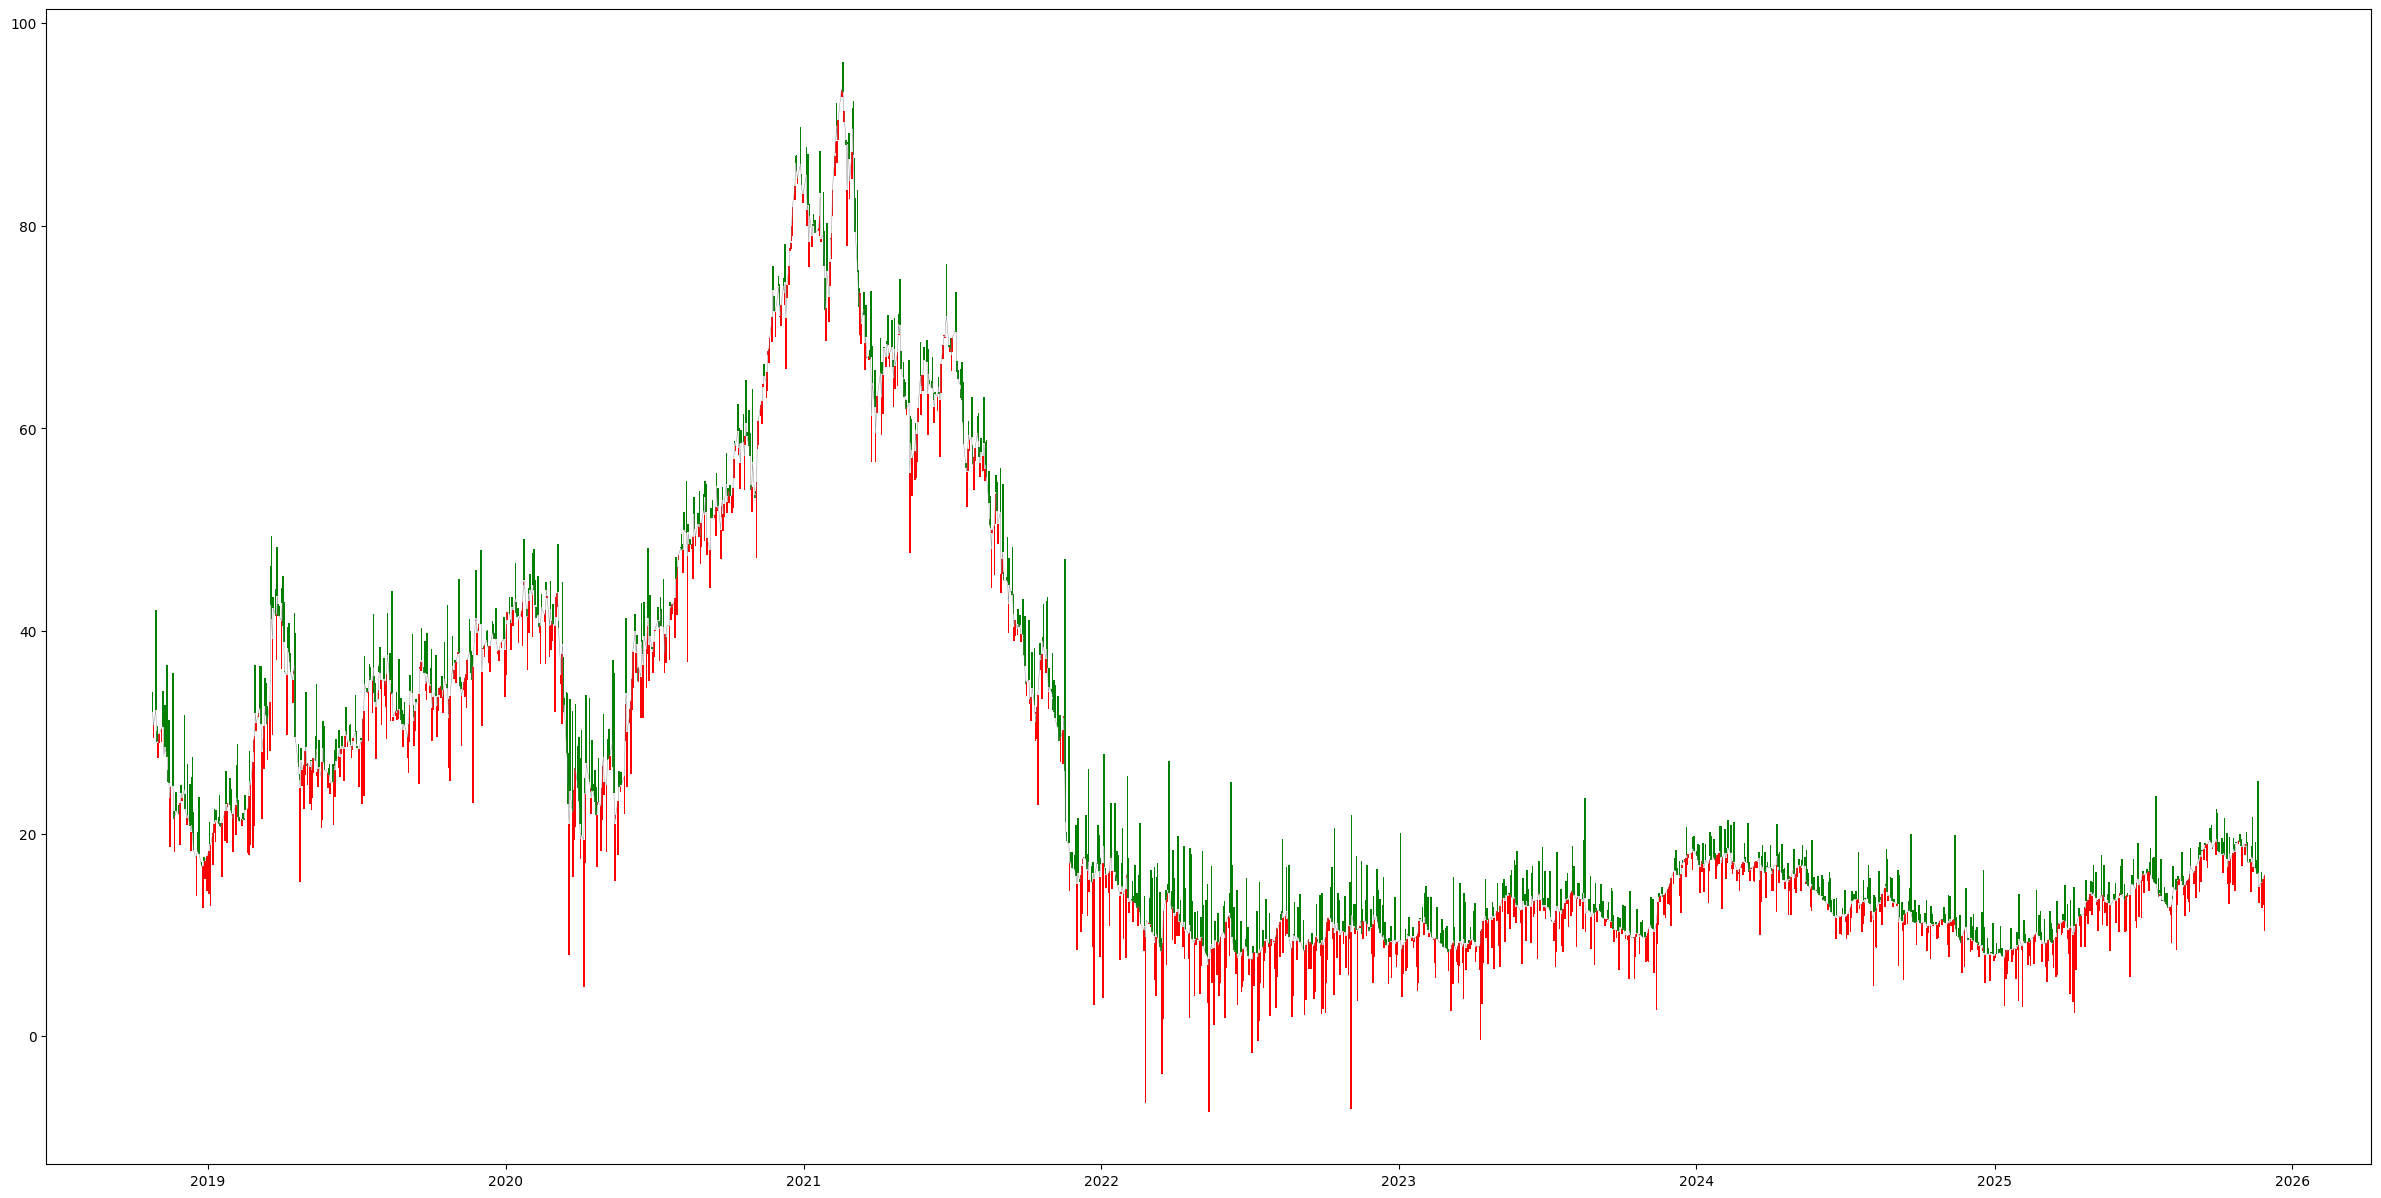

In [33]:
plt.figure(figsize=(30, 15))
plt.bar(df['Date'], df['Variacao'] * 100, bottom=df['Open'], color=colours_np, width = 2)
plt.plot(df['Date'], df['Open'], linewidth = 0.3, color='grey')
plt.show()

In [34]:
plt.clf()
higher = np.where(np.abs(df['Variacao'])> 0.1) # Buscar um numero bom para isso
df_higher = df.loc[higher]
df_higher.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Variacao
17,2018-11-19,24.740000,25.000000,21.799999,22.000000,3321500,0.0,0.0,0.110752
119,2019-04-18,29.549999,29.600000,24.799999,26.510000,32834600,0.0,0.0,0.102876
201,2019-08-15,33.919998,34.490002,30.209999,30.520000,7326100,0.0,0.0,0.100236
271,2019-11-22,36.490002,41.570000,36.240002,41.389999,11170200,0.0,0.0,-0.134283
350,2020-03-19,20.920000,25.370001,19.080000,23.620001,5508000,0.0,0.0,-0.129063


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

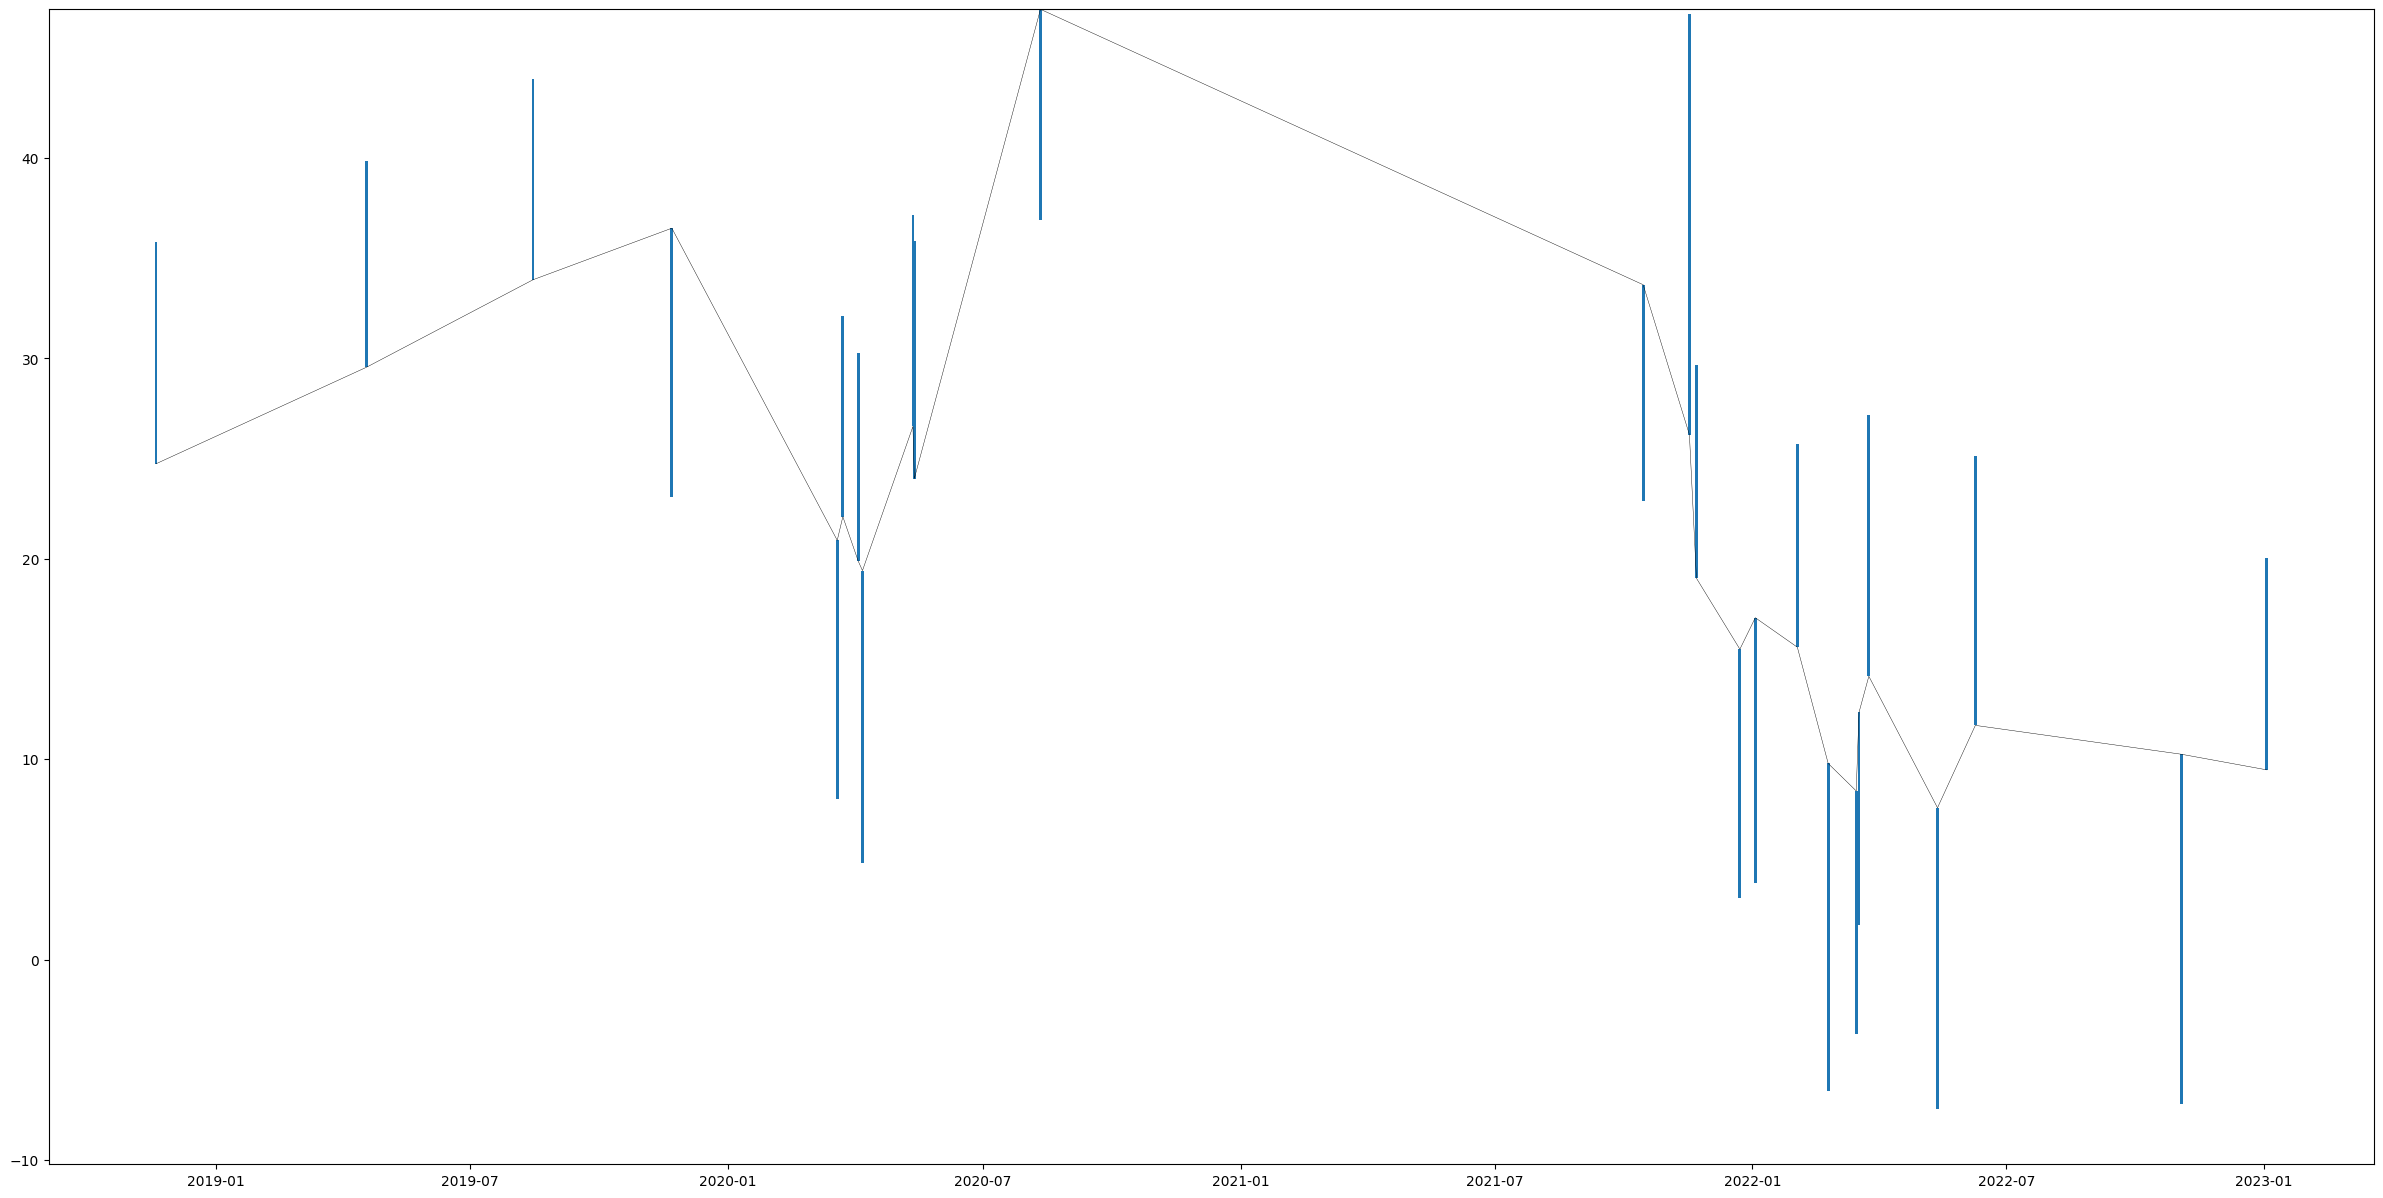

In [38]:
plt.clf()
plt.figure(figsize=(30, 15))
plt.bar(df_higher['Date'], df_higher['Variacao'] * 100, bottom=df_higher['Open'], width = 2)
plt.plot(df_higher['Date'], df_higher['Open'], linewidth = 0.3, color='black')
plt.show()

In [37]:
len(df_higher[['Date', 'Variacao']])

25